In [1]:
import sys
sys.path.append('../../')

In [2]:
import data.loader

In [3]:
(train, train_y), (test, test_y), (_, _), one_hot_encoder_X, one_hot_encoder_y = data.loader.encode_and_partition(
    data.loader.diabetic_data_raw
)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import wandb
import os

wandb.init(project="latentLinearRegression", config={
    # "ae_encoder_run_path": "charles-s-strauss-n-a/ae/runs/l5uu22fm",
    "ae_encoder_run_path": "charles-s-strauss-n-a/ae/runs/ugoaq6gb",
})

wandb: Currently logged in as: charles-s-strauss (charles-s-strauss-n-a). Use `wandb login --relogin` to force relogin


In [5]:
aeweights = wandb.restore(
    'autoencoder.pth',
    run_path=wandb.config.ae_encoder_run_path
)

In [6]:
aeweights.name

'/scratch/u1319464/BMI6015-diabetes-final/models/latentlinearregression/wandb/run-20241203_143955-lbpx64zr/files/autoencoder.pth'

In [7]:
import importlib.util

with wandb.restore('files/model.py',
    run_path="charles-s-strauss-n-a/ae/runs/swuez1st") as modelpy:
    
    spec = importlib.util.spec_from_loader(modelpy.name, loader=None)
    aemodel = importlib.util.module_from_spec(spec)
    exec(modelpy.read(), aemodel.__dict__)

aemodel

<module '/scratch/u1319464/BMI6015-diabetes-final/models/latentlinearregression/wandb/run-20241203_143955-lbpx64zr/files/files/model.py'>

In [8]:
input_dim = train.shape[1]
ae = aemodel.AutoEncoder(input_dim=input_dim, hidden_dim=128//4, latent_dim=64//4)

In [9]:
ae.load_state_dict(torch.load(aeweights.name))

<All keys matched successfully>

In [10]:
def extract_latent_space(model, data_loader):
    model.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].view(-1, input_dim)
            encoded = model.encoder(inputs)
            latent_space.append(encoded)
    latent_space = torch.cat(latent_space).cpu().numpy()
    return latent_space

In [11]:

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])

train_data = torch.from_numpy(train.toarray().astype(np.float32))
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_data = torch.from_numpy(test.toarray().astype(np.float32))
test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
latents = extract_latent_space(ae, train_loader)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
model = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression())
    ]
)
model.fit(latents, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

Positive = "<30"


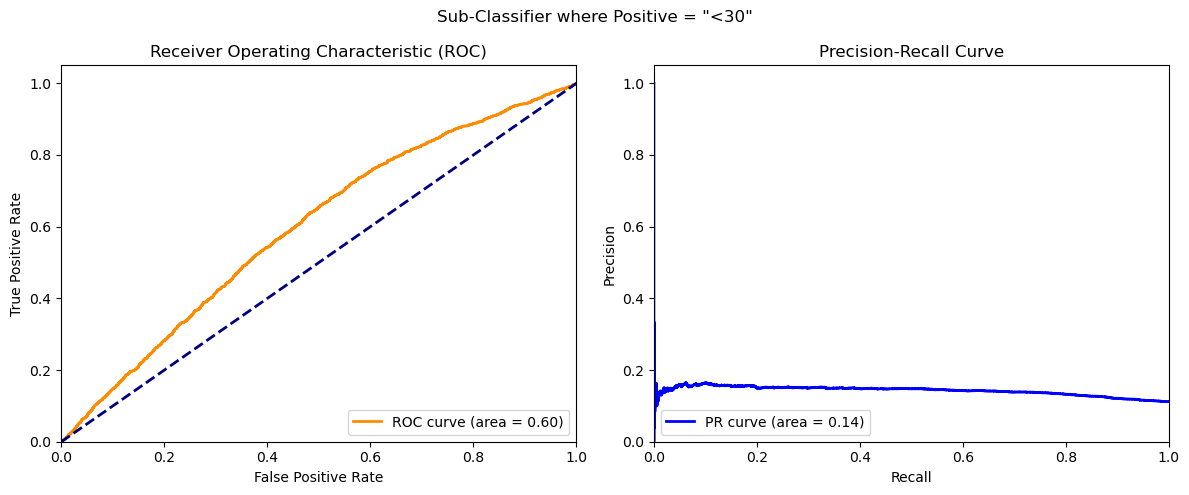

Positive = ">30"


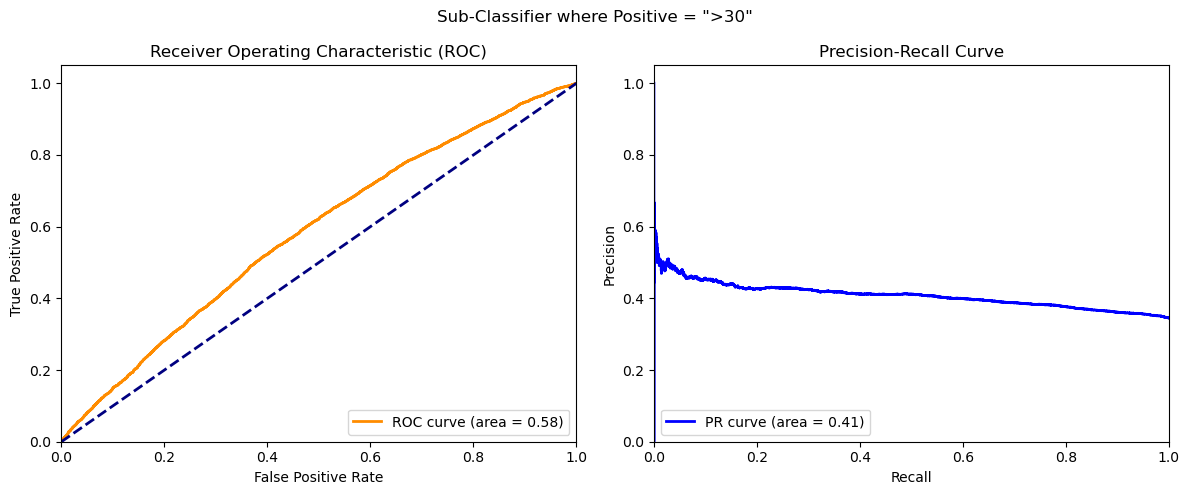

Positive = "NO"


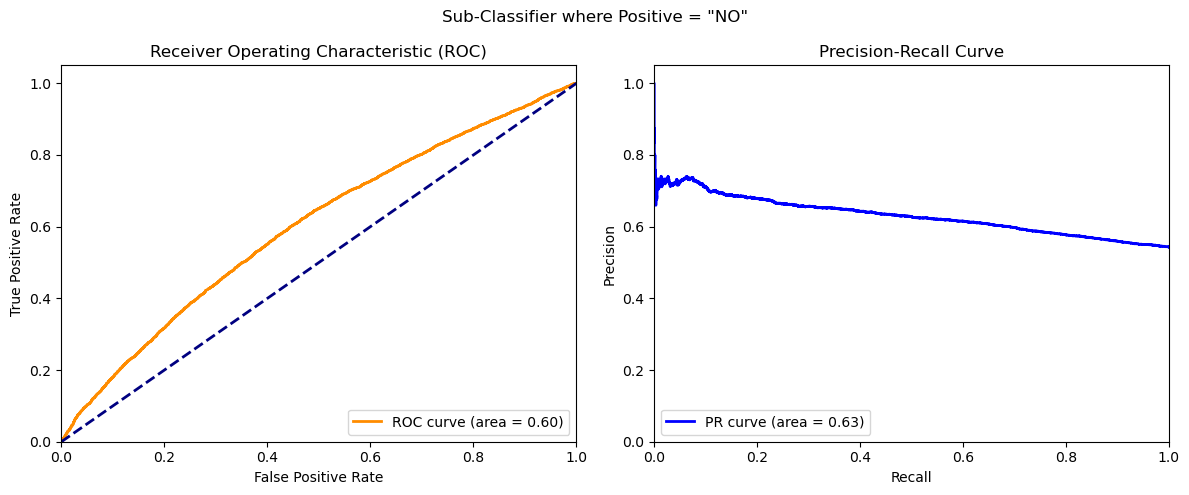

In [15]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

testY_proba = test_y
y_pred_proba = model.predict(extract_latent_space(ae, test_loader))

def unit(a):
    # return a
    return np.divide(a, np.linalg.norm(a, axis=-1, keepdims=True))


for i, category_value in enumerate(one_hot_encoder_y.categories_[0]):

    print(f'Positive = "{category_value}"')

    y_pred = y_pred_proba[:,i]
    
    testY = testY_proba[:,i]
    
    fpr, tpr, _ = roc_curve(testY, y_pred, pos_label=1)
    precision, recall, _ = precision_recall_curve(testY, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    fig, (roc, prc) = plt.subplots(1, 2, figsize=(12, 5))

    plt.suptitle(f'Sub-Classifier where Positive = "{category_value}"')
    
    roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc.set_xlim([0.0, 1.0])
    roc.set_ylim([0.0, 1.05])
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.set_title('Receiver Operating Characteristic (ROC)')
    roc.legend(loc="lower right")
    
    prc.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    prc.set_xlim([0.0, 1.0])
    prc.set_ylim([0.0, 1.05])
    prc.set_xlabel('Recall')
    prc.set_ylabel('Precision')
    prc.set_title('Precision-Recall Curve')
    prc.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
